# Do some imports

In [12]:
import numpy as np
import pandas as pd

import torch
import torch.utils.data
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader, Dataset

#needed to create the Neural Network
import torch.nn as nn
import torch.nn.functional as F

#needed to preprocess the dataset
from sklearn import preprocessing
from sklearn.metrics import accuracy_score

%matplotlib notebook
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import itertools

from dataloader import UNSW_NB15

#general
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

# Load the TensorBoard notebook extension
from torch.utils.tensorboard import SummaryWriter

### Inspired by [this github file](https://github.com/alik604/cyber-security/blob/master/Intrusion-Detection/UNSW_NB15%20-%20Torch%20MLP%20and%20autoEncoder.ipynb)

# Get UNSW_NB15 train and test set

In [13]:
#!wget https://www.unsw.adfa.edu.au/unsw-canberra-cyber/cybersecurity/ADFA-NB15-Datasets/a%20part%20of%20training%20and%20testing%20set/UNSW_NB15_training-set.csv

In [14]:
#!wget https://www.unsw.adfa.edu.au/unsw-canberra-cyber/cybersecurity/ADFA-NB15-Datasets/a%20part%20of%20training%20and%20testing%20set/UNSW_NB15_testing-set.csv

# Define the Neural Network class

In [15]:
# define NN architecture
class Net(nn.Module):
    
    def __init__(self, input_size,hidden1, hidden2, hidden3, num_classes):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden1)
        self.batchnorm1 = nn.BatchNorm1d(hidden1)
        self.relu1 = nn.ReLU()
        self.dout = nn.Dropout(0.5)
        
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.batchnorm2 = nn.BatchNorm1d(hidden2)
        self.relu2 = nn.ReLU()

        
        self.fc3 = nn.Linear(hidden2, hidden3)
        self.batchnorm3 = nn.BatchNorm1d(hidden3)
        self.relu3 = nn.ReLU()

        
        self.out = nn.Linear(hidden3, num_classes)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        a1 = self.fc1(x)
        b1 = self.batchnorm1(a1)
        h1 = self.relu1(b1)
        dout1 = self.dout(h1)
        
        a2 = self.fc2(dout1)
        b2 = self.batchnorm2(a2)
        h2 = self.relu2(b2)
        dout2 = self.dout(h2)
        
        a3 = self.fc3(dout2)
        b3 = self.batchnorm3(a3)
        h3 = self.relu3(b3)
        dout3 = self.dout(h3)
        
        a4= self.out(dout3)
        y = self.sigmoid(a4)
        return y

### Define Train,   Test   and    Display_Loss_Plot    methods

In [16]:
def train(model, device, train_loader, optimizer, criterion):
    losses = []
    model.train()
    y_true = []
    y_pred = []
    
    for i, data in enumerate(train_loader, 0):
        
        # get the inputs; data is a list of [inputs, target ( or labels)]
        inputs , target = data
        
        optimizer.zero_grad()
        
        #MOVING THE TENSORS TO THE CONFIGURED DEVICE
        #inputs, target = inputs.to(device), target.to(device)
        
        #FORWARD PASS
        output = model(inputs.float())
        loss = criterion(output, target)
        
        #BACKWARD AND OPTIMIZE
        
        loss.backward()
        optimizer.step()
        
        # PREDICTIONS
        #pred = np.round(output.detach().numpy())
        pred = output.detach().numpy() > 0.5  
        target = target.float()
        y_true.extend(target.tolist()) 
        y_pred.extend(pred.reshape(-1).tolist())
        
        losses.append(loss.data.numpy()) 
    #print("Accuracy on training set is" , accuracy_score(y_true,y_pred))
    return losses

In [45]:
#TESTING THE MODEL
def test(model, device, test_loader):
    #model in eval mode skips Dropout etc
    model.eval()
    y_true = []
    y_pred = []
    
    # set the requires_grad flag to false as we are in the test mode
    with torch.no_grad():
        for data in test_loader:
            
            #LOAD THE DATA IN A BATCH
            inputs ,target = data
            
            # moving the tensors to the configured device
            #data, target = data.to(device), target.to(device)
            
            #print('inputs are', inputs)
            # the model on the data
            #output = model(inputs.float())
            output = model(inputs.float())
            print('--------------output is', output)
                       
            #PREDICTIONS
            #pred = np.round(output)
            print('--------------output NOT processed is', pred)
            pred = output.detach().numpy() > 0.5 
            pred = pred * 1
            print('--------------output processed is', pred)
            print('--------------correct output is',target)
            target = target.float()
            y_true.extend(target.tolist()) 
            y_pred.extend(pred.reshape(-1).tolist())
    
            
    #print("Accuracy on test set is" , accuracy_score(y_true,y_pred))
    #print("***********************************************************")
    return accuracy_score(y_true, y_pred)

In [39]:
def display_loss_plot(losses):
    x_axis = [i for i in range(len(losses))]
    plt.plot(x_axis,losses)
    plt.title('Loss of the model')
    plt.xlabel('iterations')
    plt.ylabel('Cross entropy loss')
    plt.show()

# Lets do each step one at the time

#### Define some parameters first

In [40]:
device = 'cpu'
input_size = 196      # 42 for integer encoding 196
hidden1 = 128      # 1st layer number of neurons
hidden2 = 64
hidden3 = 32
num_classes = 1    # binary classification

num_epochs = 80
BATCH_SIZE = 100 

#### Initialize Neural Network class

In [41]:
model = Net(input_size, hidden1, hidden2, hidden3, num_classes)
#model = Net(input_size, hidden_size, num_classes)
print(model)

Net(
  (fc1): Linear(in_features=196, out_features=128, bias=True)
  (batchnorm1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (dout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (batchnorm2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (batchnorm3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (out): Linear(in_features=32, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


#### Define loss and optimizer 

In [39]:
criterion = nn.BCELoss()
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999))

#### Initialize UNSW_NB15 class

In [40]:
#these are not slitted into validation and train set
#train_dataset = UNSW_NB15(file_path ='UNSW_NB15_training-set.csv')
#train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE_1, shuffle=not False)

#get the train and validation set splitted.
train_dataset = UNSW_NB15(file_path ='UNSW_NB15_train.csv') 
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

val_dataset = UNSW_NB15(file_path ='UNSW_NB15_val.csv') 
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)


#get the test dataframe
test_dataset = UNSW_NB15(file_path ='UNSW_NB15_testing-set.csv')
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)


torch.Size([140341, 197])
torch.Size([35000, 197])
torch.Size([82332, 197])


#### Lets Train, Test the model and see the loss

In [48]:
running_loss = []
num_epochs=4
for epoch in tqdm(range(num_epochs)):
        loss_epoch = train(model, device, train_loader, optimizer,criterion)
        running_loss.append(loss_epoch)


#### Done training, get the test accuracy and the loss

In [51]:
test(model,device,test_loader)

0.5837827333236166

<IPython.core.display.Javascript object>


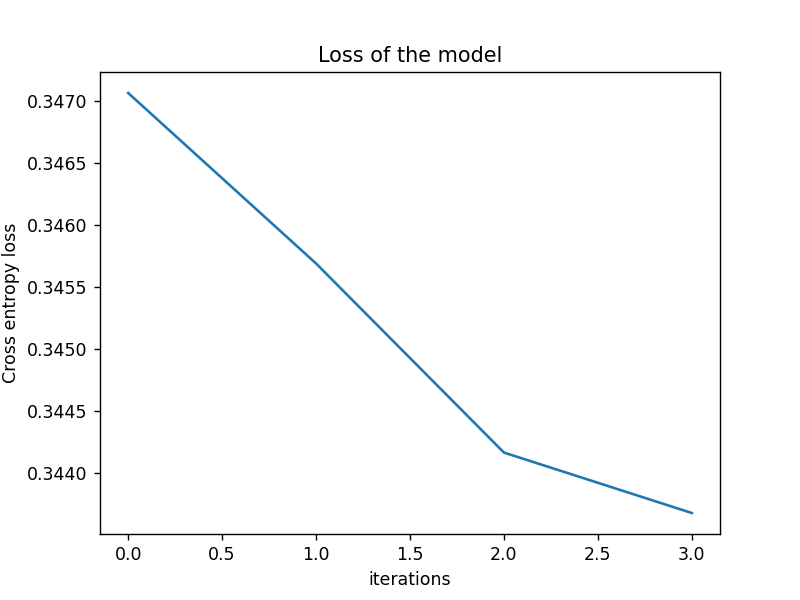

In [50]:
loss_per_epoch = [np.mean(loss_per_epoch) for loss_per_epoch in running_loss]
display_loss_plot(loss_per_epoch)

**********************************************************************************************************************

# Automatize the process of training

#### Define the fixed parameters

In [19]:
device = 'cpu'
input_size = 196      # 42 for integer encoding 196
hidden1 = 128      # 1st layer number of neurons
hidden2 = 64
hidden3 = 32
num_classes = 1    # binary classification

#### Get the dataloader

In [20]:
train_dataset = UNSW_NB15(file_path ='UNSW_NB15_train.csv') 
val_dataset = UNSW_NB15(file_path ='UNSW_NB15_val.csv') 

torch.Size([140341, 197])
torch.Size([35000, 197])


#### Create the statistics dataframe which will register all th experiments

In [27]:
df_stat = pd.DataFrame(columns = ['batch','epochs','lr','out_loss_per_epoch', 'out_accuracy_val_set'])
#create list with epoch,batch,lr
listOLists = [[2,500,1_000],[10_000,5_000,1_000,500,100],[0.001,0.005,0.01,0.05,0.1,0.2]] 
for tuples in itertools.product(*listOLists):
    row_series = pd.Series(tuples,index=['epochs','batch','lr'])
    df_stat = df_stat.append(row_series, ignore_index = True)

cols=['batch','epochs']
df_stat[cols] = df_stat[cols].applymap(np.int32)
df_stat['out_loss_per_epoch'] = df_stat['out_loss_per_epoch'].astype(object)
df_stat.head()

batch  epochs     lr out_loss_per_epoch  out_accuracy_val_set
0  10000       2  0.001                NaN                   NaN
1  10000       2  0.005                NaN                   NaN
2  10000       2  0.010                NaN                   NaN
3  10000       2  0.050                NaN                   NaN
4  10000       2  0.100                NaN                   NaN

#### Run the experiments

In [50]:
print('Lets try out all combinations from the dataframe..')
for  row in tqdm(df_stat.itertuples(), total=df_stat.shape[0]):
    train_dataset = UNSW_NB15(file_path ='UNSW_NB15_train.csv')    
    train_loader = DataLoader(train_dataset, batch_size=row.batch, shuffle=True)
    val_dataset = UNSW_NB15(file_path ='UNSW_NB15_val.csv') 
    val_loader = DataLoader(val_dataset, batch_size=row.batch, shuffle=True)

    #reset everything
    model = Net(input_size, hidden1, hidden2, hidden3, num_classes)
    print("1model is {}".format(model))
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=row.lr)
    print("model paraeters",model.parameters )
    
    e_losses = []
    loss_per_epoch = []
    
    print('Iterating over the epochs...')
    for epoch in tqdm(range(row.epochs)):
        e_losses.append([train(model, device, train_loader, optimizer, criterion)])
        
    
    loss_per_epoch = [np.mean(loss_per_epoch) for loss_per_epoch in e_losses]    
    print("2loss_per_epoch is {}".format(loss_per_epoch))
    
    #update the dataframe with the losses and accuracy
    df_stat.at[row.Index, 'out_loss_per_epoch'] = loss_per_epoch
    df_stat.at[row.Index, 'out_accuracy_val_set'] = test(model, device, val_loader)
    print(test(model, device, val_loader))
    print("3model is {}".format(model))
    df_stat.to_csv("data/df_stat_1hotEnco.csv") #save to csv
    
    if row.Index ==1:
        break

Lets try out all combinations from the dataframe..


torch.Size([140341, 197])
torch.Size([35000, 197])
1model is Net(
  (fc1): Linear(in_features=196, out_features=128, bias=True)
  (batchnorm1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (dout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (batchnorm2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (batchnorm3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (out): Linear(in_features=32, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
model paraeters <bound method Module.parameters of Net(
  (fc1): Linear(in_features=196, out_features=128, bias=True)
  (batchnorm1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (dout): Dropout(p=0.5, inplace=False)
  (fc2): Li

C:\Users\alinav\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([10000])) that is different to the input size (torch.Size([10000, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)
C:\Users\alinav\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([341])) that is different to the input size (torch.Size([341, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)



2loss_per_epoch is [0.6801431, 0.5927764]
--------------output is tensor([[0.4603],
        [0.6417],
        [0.4680],
        ...,
        [0.4592],
        [0.5293],
        [0.4626]])
--------------output processed is [[0]
 [1]
 [0]
 ...
 [0]
 [1]
 [0]]
--------------correct output is tensor([0., 0., 0.,  ..., 0., 0., 0.])
--------------output is tensor([[0.6417],
        [0.6417],
        [0.6417],
        ...,
        [0.4693],
        [0.5224],
        [0.6417]])
--------------output processed is [[1]
 [1]
 [1]
 ...
 [0]
 [1]
 [1]]
--------------correct output is tensor([0., 0., 0.,  ..., 0., 0., 0.])
--------------output is tensor([[0.6417],
        [0.4913],
        [0.6417],
        ...,
        [0.5219],
        [0.5021],
        [0.4974]])
--------------output processed is [[1]
 [0]
 [1]
 ...
 [1]
 [1]
 [0]]
--------------correct output is tensor([0., 0., 0.,  ..., 0., 0., 0.])
--------------output is tensor([[0.5078],
        [0.4767],
        [0.4728],
        ...,
     

C:\Users\alinav\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([10000])) that is different to the input size (torch.Size([10000, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)
C:\Users\alinav\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([341])) that is different to the input size (torch.Size([341, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)



2loss_per_epoch is [0.5290717, 0.41894105]
--------------output is tensor([[0.7002],
        [0.6831],
        [0.7127],
        ...,
        [0.8173],
        [0.7056],
        [0.6978]])
--------------output processed is [[1]
 [1]
 [1]
 ...
 [1]
 [1]
 [1]]
--------------correct output is tensor([0., 0., 0.,  ..., 0., 0., 0.])
--------------output is tensor([[0.6823],
        [0.8173],
        [0.8173],
        ...,
        [0.7024],
        [0.8177],
        [0.6981]])
--------------output processed is [[1]
 [1]
 [1]
 ...
 [1]
 [1]
 [1]]
--------------correct output is tensor([0., 0., 0.,  ..., 0., 0., 0.])
--------------output is tensor([[0.8173],
        [0.7137],
        [0.6612],
        ...,
        [0.7101],
        [0.8173],
        [0.7005]])
--------------output processed is [[1]
 [1]
 [1]
 ...
 [1]
 [1]
 [1]]
--------------correct output is tensor([0., 0., 0.,  ..., 0., 0., 0.])
--------------output is tensor([[0.8173],
        [0.7489],
        [0.6979],
        ...,
    

#### Now lets try it out on the test set

In [ ]:
#get the test dataframe
test_dataset = UNSW_NB15(file_path ='UNSW_NB15_testing-set.csv')
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)